## LSTM을 이용한 네이버 영화 리뷰 분류
이번에 사용할 데이터는 네이버 영화 리뷰 데이터입니다. 총 200,000개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1, 부정인 경우 0을 표시한 레이블로 구성되어져 있습니다. 해당 데이터를 다운로드 받아 감성 분류를 수행하는 모델을 만들어보겠습니다.

### 네이버 영화 리뷰 데이터에 대한 전처리
데이터 다운로드 링크 : https://github.com/e9t/nsmc/

In [33]:
!pip install konlpy

In [34]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

### 1. 데이터 로드하기
위 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드합니다.

In [35]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x7db33f89be90>)

pandas를 이용한 훈련데이터는 train_data에 테스트 데이터는 test_data에 저장합니다.

In [36]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data에 존재하는 영화 리뷰의 개수를 확인해보고 상위 5개 샘플을 출력해봅시다.

In [37]:
print('훈련용 리뷰 개수 :',len(train_data))
train_data[:5]

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시합니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 되어야 합니다

또한 단지 상위 5개의 샘플만 출력해보았지만 한국어 데이터와 영어 데이터의 차이를 확인할 수 있습니다. 예를 들어, 인덱스 2번 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 되어있지 않습니다. test_data의 리뷰 개수와 상위 5개의 샘플을 확인해봅시다.

In [38]:
print('테스트용 리뷰 개수: ', len(test_data))
test_data[:5]

테스트용 리뷰 개수:  50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


test_data도 train_data와 동일한 형식으로 id, document, label 3개의 열로 구성되어져 있습니다.

###2. 데이터 정제하기
train_data의 데이터 중복 유무 확인

In [39]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미입니다. label 열은 0 또는 1의 두 가지 값만을 가지므로 2가 출력됩니다. 중복 샘플을 제거합니다.

In [40]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


중복 샘플이 제거되었습니다. train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 보겠습니다.

<Axes: xlabel='label'>

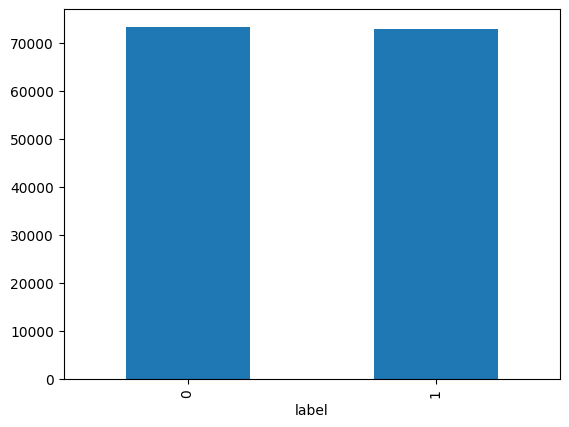

In [41]:
train_data['label'].value_counts().plot(kind = 'bar')

앞서 확인하였듯이 약 146,000개의 영화 리뷰 샘플이 존재하는데 그래프 상으로 긍정과 부정 둘 다 약 72,000개의 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보입니다. 정확하게 몇 개인지 확인해봅시다.

In [42]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


레이블이 0인 리뷰가 근소하게 많습니다. 리뷰 중에 Null 값을 가진 샘플이 있는지 확인합니다.

In [43]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다. 어떤 열에 존재하는지 확인하고 제거 합니다.

In [44]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [45]:
# Null 값을 가진 샘플을 제거하겠습니다.
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 삭제
print(train_data.isnull().values.any()) # 널 값 존재 확인

False


Null 값을 가진 샘플이 제거되었습니다. 다시 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인해봅시다.

In [46]:
print(len(train_data))

146182


데이터의 전처리를 수행해보겠습니다. 위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해봅시다.

In [47]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", regex=True)
train_data[:5]

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다. 사실 네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다. 다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다. train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [48]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


Null 값이 789개나 새로 생겼습니다. Null 값이 있는 행을 5개만 출력해볼까요?

In [49]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 아무런 의미도 없는 데이터므로 제거해줍니다.

In [50]:
train_data= train_data.dropna(how= 'any')
print(len(train_data))

145393


샘플 개수가 또 다시 줄어서 145,393개가 남았습니다. 테스트 데이터에 앞서 진행한 전처리 과정을 동일하게 진행합니다.

In [51]:
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", regex=True)
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


###3. 토큰화
토큰화를 진행해봅시다. 토큰화 과정에서 불용어를 제거하겠습니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있습니다.

In [52]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

여기서는 위 정도로만 불용어를 정의하고, 토큰화를 위한 형태소 분석기는 KoNLPy의 Mecab을 사용합니다. Mecab을 복습해봅시다

In [53]:
# # 1. MeCab 설치 스크립트 클론
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

# # 2. 디렉토리 이동
# %cd Mecab-ko-for-Google-Colab

# # 3. 설치 스크립트 실행
# !bash install_mecab-ko_on_colab_light_220429.sh

In [54]:
from konlpy.tag import Mecab

mecab = Mecab()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')


['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다고 언급한 바 있습니다. train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

In [55]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)


100%|██████████| 145393/145393 [00:22<00:00, 6373.29it/s]


상위 3개의 샘플만 출력하여 결과를 확인해봅시다.

In [56]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '요목', '소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [57]:
# 테스트 데이터에 대해서도 동일하게 토큰화를 해줍니다.
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [00:04<00:00, 10986.10it/s]


지금까지 훈련 데이터와 테스트 데이터에 대해서 텍스트 전처리를 진행해보았습니다. 이제 학습 데이터와 검증 데이터, 그리고 테스트 데이터를 준비해보겠습니다.



###4. 학습데이터, 검증 데이터, 테스트 데이터
이미 학습 데이터와 테스트 데이터는 준비되었지만 학습하는 동안의 성능 평가를 진행할 검증 데이터가 추가로 필요합니다. 데이터프레임의 레이블 열을 별도로 분리하여 y_train과 y_test로 저장해줍니다. 이제 학습 데이터는 X_train, y_train에 저장되고, 테스트 데이터는 X_test, y_test에 저장이 될 것입니다.

학습 데이터 중에서 20%를 분할하여 추가로 검증 데이터를 만들어줍니다. 머신 러닝 문제를 풀 때, 데이터의 분리는 주로 사이킷런에서 제공하는 train_test_split을 사용해 진행합니다. test_size에 비율을 넣어주면 기존 데이터에 대해서 해당 비율만큼 일부 데이터를 분할하여 반환합니다.

랜덤으로 분할하는 과정에서 레이블 불균형이 발생하지 않도록, 레이블의 균형 비율을 유지하면서 분할하고 싶다면 분할 시 기존 데이터의 y데이터를 stratify의 값으로 사용하면 됩니다.

In [58]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [59]:
# 실제로 비율이 잘 유지되면서 분할되었는지 확인해봅시다.
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


분할 후에도 학습 데이터와 검증 데이터의 레이블 비율이 동일한 것을 확인할 수 있습니다.

###5. 단어 집합 만들기
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련데이터에 대해서 단어집합(vocaburary)을 만들어 봅시다.

In [60]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 51971


단어가 5만개가 넘게 존재합니다. 등장 빈도를 카운트 하는 Counter()를 사용하였기 때문에 각 단어의 등장 빈도가 저장되어져 있습니다. 단어 영화와 공감의 등장 빈도를 출력합니다.

In [62]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 44607
훈련 데이터에서의 단어 공감의 등장 횟수 : 725


등장 빈도수가 높은 순서대로 단어들을 정렬해봅시다.

In [63]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [64]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 51971
등장 빈도가 2번 이하인 희귀 단어의 수: 32354
단어 집합에서 희귀 단어의 비율: 62.253949317888825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.822997787292738


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 2.82%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [65]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 19617


단어 집합의 크기는 19,617개입니다. 이제 패딩 토큰와 모르는 단어에 대응하기 위해서 실제 의미를 가지는 단어는 아니지만 임의로 단어 집합에 PAD와 UNK를 추가합니다. 이렇게 특별한 용도로 사용되는 단어들을 스페셜 토큰(Special Token)이라고 합니다. 두 개의 스페셜 토큰은 각각 정수 0과 1에 할당하고, 두 개의 스페셜 토큰이 추가된 후의 단어 집합의 크기를 확인해봅시다.

In [67]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab):
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 unk 토큰을 고려한 단어 집합의 크기 :',vocab_size)

패딩 토큰과 unk 토큰을 고려한 단어 집합의 크기 : 19619


###6. 정수 인코딩
이제 정수 인코딩을 진행해봅시다. 현재 등장 빈도가 2회 이하인 단어들은 단어 집합에서 제거하였으므로 정수 인코딩 과정에서는 단어 집합에 존재하지 않는 단어들은 일괄로 UNK로 맵핑합니다. 다시 말해서 정수 1로 맵핑합니다.

In [68]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
        index_sequences.append(word_to_index[word])
      except KeyError:
        index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 전부 정수 인코딩을 진행합니다.

In [69]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

정수 인코딩 후의 상위 2개 샘플을 출력해봅시다.

In [71]:
for sent in encoded_X_train[:2]:
  print(sent)

[950, 1923, 126, 7, 80, 47, 32]
[2390, 3125, 4, 2082, 411, 89, 5458, 18, 309]


단어를 key로, 정수를 value로 가지는 단어 집합 딕셔너리인 word_to_index의 key와 value를 뒤집어서 정수가 key이고, 단어가 value인 index_to_word를 만들어봅시다. 그리고 index_to_word를 이용하여 정수 인코딩 결과를 역으로 다시 텍스트로 변환해봅시다. 이를 디코딩이라고 합니다

In [73]:
index_to_word = {}
for key, value in word_to_index.items():
  index_to_word[value] = key

In [74]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


### 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이:  74
리뷰의 평균 길이:  11.967261034785151


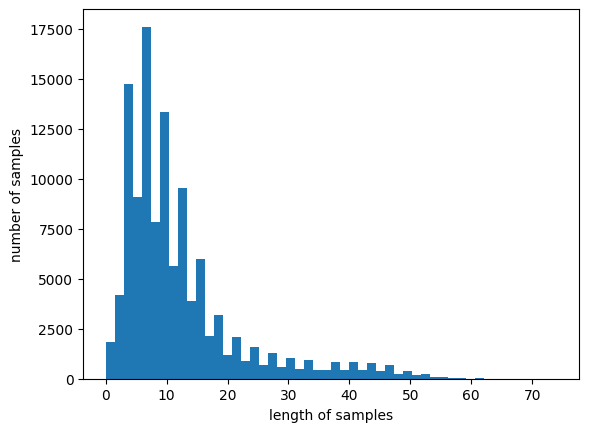

In [75]:
print('리뷰의 최대 길이: ', max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이: ', sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 74이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 12내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [77]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

위의 분포 그래프를 봤을 때, max_len = 30이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다.

In [78]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.68273810547312


전체 훈련 데이터 중 약 92%의 리뷰가 30이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 30으로 맞추겠습니다.

In [80]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) !=0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


훈련 데이터의 첫번째 샘플을 출력해봅시다.

In [81]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 950 1923  126    7   80   47   32    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


훈련 데이터의 첫번째 샘플을 출력하면 길이 30을 맞추기 위해서 뒤에 숫자 0이 붙어있는 것을 확인할 수 있습니다.

## LSTM을 이용한 네이버 영화 리뷰 분류 모델
이제 딥 러닝 프레임워크 PyTorch를 이용하여 LSTM 모델을 구현해봅시다.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [83]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함: ", device)

cpu와 cuda 중 다음 기기로 학습함:  cpu


저의 경우 Colab에서 GPU를 선택하여 실습을 진행하여 cuda라는 출력 결과를 확인했습니다. 레이블 데이터를 파이토치의 텐서 타입으로 변환합니다. 이후 훈련 데이터의 상위 5개의 레이블을 출력해보았습니다

In [84]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


이제 LSTM 모델을 클래스로 구현해봅시다. 각 층을 지날 때마다 각 층의 출력의 크기를 이해하는 것이 중요합니다. 예를 들어 입력은 (배치 크기, 문장 길이)의 크기를 가지는 텐서입니다. 임베딩 층을 지나고 나면 각 단어가 임베딩 벡터로 변환되면서 (배치 크기, 문장 길이, 임베딩 벡터의 차원)으로 텐서의 크기가 변환됩니다.

이 후 LSTM의 마지막 시점의 은닉 상태(hidden state) 값을 출력층과 연결시키는 작업을 해주어야 합니다. 이때 LSTM이 출력층으로 보는 결과값의 차원은 (배치 크기, 은닉 상태의 차원)을 가져야 합니다. 마지막 시점의 은닉 상태의 값만 전달하므로 은닉 상태는 모든 시점(문장 길이)만큼 존재하는 것이 아니라 단 하나만 있습니다. 출력층은 지난 결과는 소프트맥스 회귀를 수행하므로 (배치 크기, 분류하고자하는 카테고리의 수)의 차원을 가지게 됩니다.

그 후 각 데이터를 배치 단위로 데이터 묶음을 꺼낼 수 있는 데이터로더로 전달합니다. 정리하면 다음과 같습니다. 아직 모델을 만들지는 않았지만, 단어 벡터의 차원을 100, 배치 크기를 32, 문장 길이를 500(패딩 후), LSTM의 은닉 상태의 차원을 128로 한다고 가정해보겠습니다.

- 단어 벡터의 차원 = 100
- 문장 길이 = 500
- 배치 크기 = 32
- 데이터 개수 = 2만
- LSTM의 은닉층의 크기 = 128
- 분류하고자 하는 카테고리 개수 = 2개

위의 정보들을 고려하였을 때 모델 내부에서 데이터의 변화는 다음과 같습니다.

(32, 500) => 입력 데이터의 형태 => 임베딩 층 통과 후 => (32, 500, 100) => LSTM 통과 후 => (32, 128) => Softmax 출력층 통과 후 => (32, 20)

In [103]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits


훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 파이토치 텐서로 변환하고 배치 단위 연산을 위해 데이터로더로 변환합니다.

In [104]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size =1)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

훈련 데이터의 샘플 개수가 116,314개 였으므로 배치 크기를 32로 할 경우에는 116,324/32=3,635 다시 말해 32개씩 묶인 데이터 묶음이 3,635개가 생깁니다. 그리고 학습 시에는 32개씩 데이터가 들어가게 될 것입니다.

In [105]:
torch.batch = len(train_dataloader)
print('총 배치의 수 : {})'.format(torch.batch))

총 배치의 수 : 3635)


In [106]:
# 모델 객체 선언
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(19619, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

임베딩 벡터의 차원은 128, 출력층의 크기(분류해야 할 카테고리의 개수)는 2로 정했습니다. 이렇게 사용자가 정해주는 값이면서 모델의 결과에 영향을 미치는 값들을 하이퍼파라미터라고 합니다. 소프트맥스 회귀를 통해 분류 문제를 진행하므로 손실 함수는 nn.CrossEntropyLoss()를 사용합니다. 파이토치로 자연어 처리를 하게 되면 가장 많이 사용하게 되는 손실 함수입니다. 하이퍼파라미터 중 하나인 학습률(learning rate)는 0.001로 정했습니다.

In [107]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## 평가 코드 작성
이후 평가를 진행하기 위해서 모델의 정확도를 측정하는 함수 calculate_accuracy()를 작성합니다.

In [108]:
def calculate_accuracy(logits, labels):
  # _, predicted = torch.max(logits, 1)
  predicted = torch.argmax(logits, 1)
  correct = (predicted == labels).sum().item()
  total = labels.size(0)
  accuracy = correct / total
  return accuracy

검증 데이터와 테스트 데이터에 대한 성능을 측정하기 위한 함수 evaluate()를 작성합니다. 아래의 함수에서 model.eval()과 with torch.no_grad()를 짚어봅시다. 이 두 개는 모델 평가를 수행할 때 중요한 역할을 합니다. 각각의 의미는 다음과 같습니다.

* model.eval(): 모델을 평가 모드로 설정합니다. 이렇게 하면 모델 내부의 모든 레이어에 대해 평가 모드가 활성화됩니다. 일부 레이어, 예를 들어 드롭아웃이나 배치 정규화는 학습과 평가 시 다르게 동작하기 때문에 이 설정이 중요합니다. 평가 모드가 설정되지 않으면, 이러한 레이어의 동작이 올바르지 않을 수 있으며, 이로 인해 평가 결과가 제대로 나오지 않을 수 있습니다.

* with torch.no_grad(): 이 문장은 자동 미분 엔진에서 기울기(gradient) 계산을 비활성화합니다. 평가 중에는 기울기를 계산할 필요가 없으므로, 이렇게 설정하면 메모리를 절약하고 속도를 높일 수 있습니다. 만약 이 설정이 적용되지 않으면, 평가 과정에서 기울기(gradient)가 계산되고 메모리를 차지하게 됩니다. 그러나 평가 결과 자체에는 직접적인 영향을 주지 않습니다.

따라서 model.eval()은 평가 시 반드시 사용해야 하며, 그렇지 않으면 평가 결과가 올바르게 나오지 않을 수 있습니다. with torch.no_grad():는 필수는 아니지만, 메모리와 속도 측면에서 권장됩니다.

In [109]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


## 학습
이제 모델을 학습해봅시다. 딥러닝 모델을 훈련하고 검증하는 과정을 반복하며, 검증 손실이 개선될 때마다 모델의 가중치를 저장합니다. 각 에포크마다 훈련 손실과 정확도를 계산하고, 검증 데이터로 모델을 평가합니다. 검증 손실이 가장 낮은 경우 해당 모델의 가중치를 파일로 저장합니다.

In [110]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 0.4861, Train Accuracy: 0.7364
Validation Loss: 0.3762, Validation Accuracy: 0.8258
Validation loss improved from inf to 0.3762. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3281, Train Accuracy: 0.8563
Validation Loss: 0.3500, Validation Accuracy: 0.8436
Validation loss improved from 0.3762 to 0.3500. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2670, Train Accuracy: 0.8867
Validation Loss: 0.3521, Validation Accuracy: 0.8487
Epoch 4/5:
Train Loss: 0.2102, Train Accuracy: 0.9139
Validation Loss: 0.3788, Validation Accuracy: 0.8439
Epoch 5/5:
Train Loss: 0.1596, Train Accuracy: 0.9374
Validation Loss: 0.4342, Validation Accuracy: 0.8424


num_epochs라는 변수를 통해 훈련을 몇 번 반복할지를 설정하며, 여기서는 5번의 반복을 수행합니다.

best_val_loss는 모델의 검증 손실 중 가장 낮은 값을 추적하는 변수입니다. 초기값은 매우 큰 값으로 설정되며, 검증 손실이 이 값보다 작으면 모델의 상태를 저장합니다.

훈련 과정에서 train_dataloader는 데이터를 배치로 묶어 모델에 입력합니다. 각 배치마다 배치 데이터(batch_X, batch_y)를 device(보통 GPU)에 올려서 모델에 입력하고, 모델로부터 예측값(logits)을 계산합니다. 이후 예측값과 실제 정답(batch_y) 사이의 손실을 계산하고, 이를 바탕으로 역전파를 통해 모델의 가중치를 업데이트합니다.

훈련이 끝나면, 훈련 손실과 정확도를 계산하고 이를 출력합니다. 검증 과정에서는 모델을 valid_dataloader로 평가하고, 검증 손실과 검증 정확도를 계산합니다. 검증 손실이 이전 최저 검증 손실보다 낮다면, 새로운 최저 검증 손실로 업데이트하고 해당 상태의 모델 가중치를 저장합니다.

이 과정은 전체 에포크 동안 반복되며, 최종적으로 성능이 가장 좋은 모델의 가중치가 저장됩니다.

## 모델 로드 및 평가
이제 베스트 모델을 로드하여 테스트 데이터에 대한 성능을 측정해 봅시다.

In [111]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

TextClassifier(
  (embedding): Embedding(19619, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

evaluate() 함수를 이용하여 검증 데이터에 대한 정확도와 손실을 출력해봅시다.

In [112]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3500
Best model validation accuracy: 0.8436


검증 데이터에 대한 정확도는 84.36%입니다. 이제 테스트 데이터에 대한 정확도와 손실을 출력해봅시다.

In [114]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3495
Best model test accuracy: 0.8425


테스트 데이터에 대한 정확도는 84.25%입니다.

## 모델 테스트
이제 임의의 입력에 대해서 예측을 하는 predict() 함수를 만듭니다.



In [115]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


먼저 model.eval()은 모델을 평가 모드로 전환합니다. 이 단계에서는 모델이 예측을 할 때 학습과정에서 사용되었던 드롭아웃 같은 기능이 비활성화됩니다. 텍스트는 word_tokenize 함수를 사용해 단어 단위로 분리되며, 각 단어는 소문자로 변환된 후 사전에 정의된 word_to_index 사전에서 해당 단어의 인덱스를 찾아 정수로 변환됩니다. 만약 사전에 없는 단어가 발견되면, 해당 단어는 로 처리되어 인덱스 1이 할당됩니다.

변환된 정수 인덱스 리스트는 PyTorch 텐서로 변환되어 모델에 입력됩니다. 이 텐서는 배치 크기가 1인 2차원 텐서로, 입력 텍스트의 각 단어가 인덱스로 변환된 결과를 담고 있습니다. with torch.no_grad() 구문은 모델의 예측 과정에서 기울기 계산을 비활성화하여 메모리와 연산 속도를 최적화합니다. 이로써 입력된 텍스트에 대해 모델의 예측값을 계산합니다.

모델의 출력인 logits는 각 감정 클래스에 대한 점수로, 이 중에서 가장 높은 점수를 가진 인덱스가 예측된 감정 클래스로 선택됩니다. 이 인덱스는 index_to_tag 사전을 통해 '긍정' 또는 '부정'이라는 문자열로 변환됩니다. 최종적으로 예측된 감정 클래스를 반환합니다.

이제 임의의 입력에 대해서 예측을 해봅시다. 영화에 대한 부정적인 리뷰를 predict() 함수의 입력으로 사용해봅시다.

In [116]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)


'긍정'

In [117]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)


'부정'

In [118]:
test_input = "감독 뭐하는 놈이냐?"
predict(test_input, model, word_to_index, index_to_tag)


'부정'

In [119]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
predict(test_input, model, word_to_index, index_to_tag)


'긍정'